In [ ]:
from google.colab import drive
import os

mount_point = '/content/drive'

os.makedirs(mount_point, exist_ok=True)

drive.mount(mount_point)


Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/colab_content/ai_project_3
! ls

/content/drive/My Drive/colab_content/ai_project_3
 a3_IMDb_Unseen_Reviews.csv	 'Copy of AIProject3(Sentiment Analysis).ipynb'
 c1_lstm_model_acc_0.77.h5	  glove.6B.100d.txt
 c1_lstm_model_acc_0.857.h5	  imdb_dataset.csv
 c1_lstm_model_acc_0.866.h5	  IMDb_Unseen_Reviews.csv
 c2_IMDb_Unseen_Predictions.csv


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
movie_reviews = pd.read_csv("imdb_dataset.csv")

In [ ]:
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

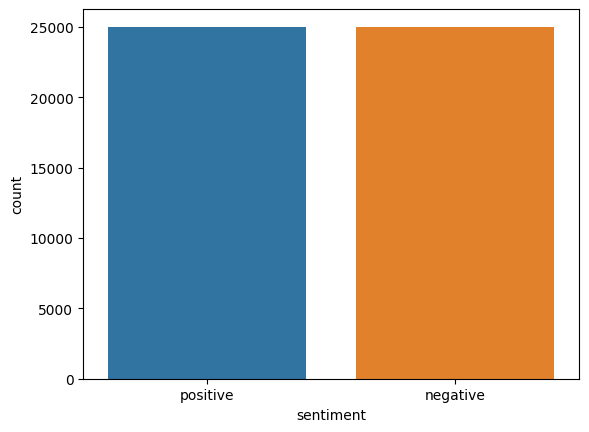

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[10]

'phil alien one quirky films humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed find jokes oddness funny anymore low budget film thats never problem pretty interesting characters eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet '

In [ ]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding layer

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [ ]:
maxlen = 130

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

# Start training model

## 1. Simple neural network

In [ ]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 100)          9239400   
                                                                 
 flatten_1 (Flatten)         (None, 13000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 13001     
                                                                 
Total params: 9252401 (35.30 MB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 3ms/step - loss: 0.5564 - acc: 0.7150 - val_loss: 0.5039 - val_acc: 0.7621
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4385 - acc: 0.8020 - val_loss: 0.4960 - val_acc: 0.7685
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3959 - acc: 0.8256 - val_loss: 0.5031 - val_acc: 0.7649
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3712 - acc: 0.8382 - val_loss: 0.5116 - val_acc: 0.7663
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3515 - acc: 0.8489 - val_loss: 0.5299 - val_acc: 0.7588
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3353 - acc: 0.8605 - val_loss: 0.5426 - val_acc: 0.7581


In [ ]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5617 - acc: 0.7547


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5617231726646423
Test Accuracy: 0.7547000050544739


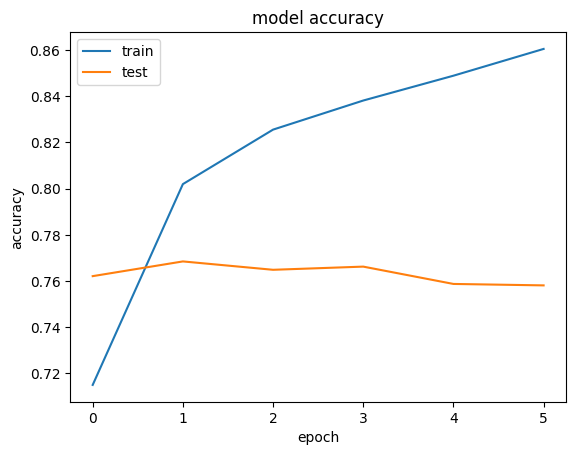

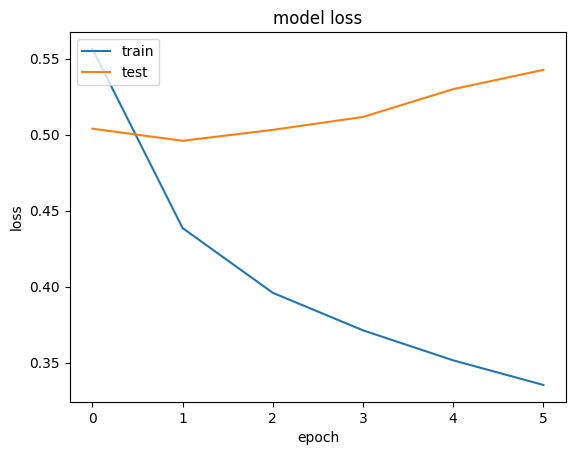

In [ ]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional neural network(CNN)

In [ ]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 130, 100)          9239400   
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4597 - acc: 0.7827 - val_loss: 0.3779 - val_acc: 0.8280
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3339 - acc: 0.8592 - val_loss: 0.3451 - val_acc: 0.8457
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2808 - acc: 0.8867 - val_loss: 0.3312 - val_acc: 0.8551
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2328 - acc: 0.9141 - val_loss: 0.3223 - val_acc: 0.8590
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.1969 - acc: 0.9327 - val_loss: 0.3234 - val_acc: 0.8609
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.1587 - acc: 0.9535 - val_loss: 0.3212 - val_acc: 0.8594


In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.3228 - acc: 0.8610


In [ ]:
print("Test Score:", score[0])
print("Test Score:", score[1])

Test Score: 0.32276451587677
Test Score: 0.8610000014305115


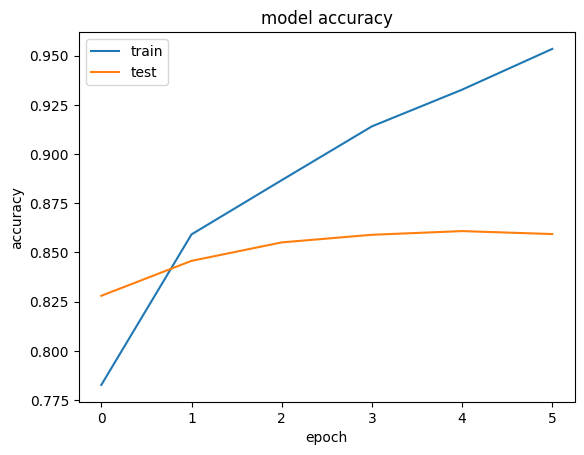

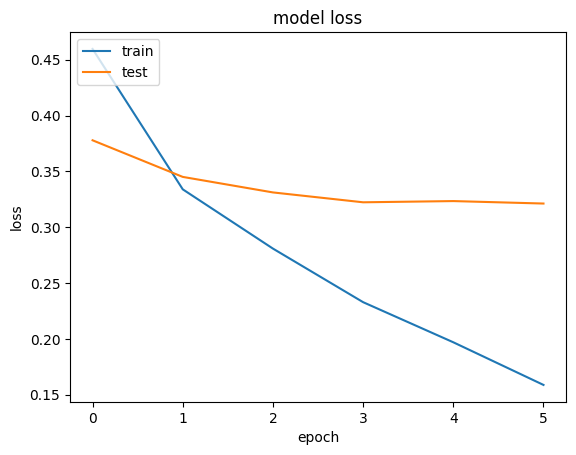

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM

In [ ]:
from keras.layers import LSTM

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 130, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 5s 13ms/step - loss: 0.5108 - acc: 0.7532 - val_loss: 0.4474 - val_acc: 0.8220
Epoch 2/6
250/250 [==============================] - 3s 10ms/step - loss: 0.4091 - acc: 0.8220 - val_loss: 0.3676 - val_acc: 0.8451
Epoch 3/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3851 - acc: 0.8367 - val_loss: 0.3521 - val_acc: 0.8525
Epoch 4/6
250/250 [==============================] - 3s 13ms/step - loss: 0.3553 - acc: 0.8503 - val_loss: 0.3529 - val_acc: 0.8562
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3240 - acc: 0.8665 - val_loss: 0.3533 - val_acc: 0.8590
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3097 - acc: 0.8754 - val_loss: 0.3319 - val_acc: 0.8700


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.3379 - acc: 0.8716


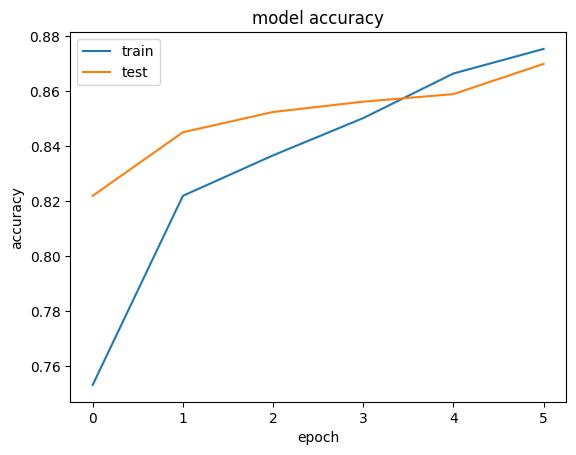

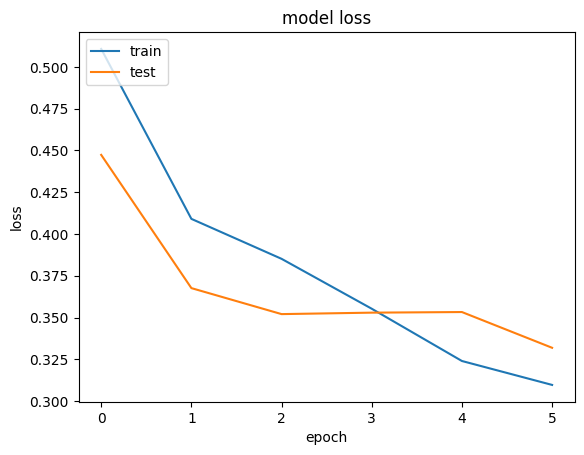

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls

 a3_IMDb_Unseen_Reviews.csv   c2_IMDb_Unseen_Predictions.csv
 c1_lstm_model_acc_0.77.h5   'Copy of AIProject3(Sentiment Analysis).ipynb'
 c1_lstm_model_acc_0.857.h5   glove.6B.100d.txt
 c1_lstm_model_acc_0.866.h5   imdb_dataset.csv
 c1_lstm_model_acc_0.872.h5   IMDb_Unseen_Reviews.csv


In [ ]:
!ls

 a3_IMDb_Unseen_Reviews.csv   c2_IMDb_Unseen_Predictions.csv
 c1_lstm_model_acc_0.77.h5   'Copy of AIProject3(Sentiment Analysis).ipynb'
 c1_lstm_model_acc_0.857.h5   glove.6B.100d.txt
 c1_lstm_model_acc_0.866.h5   imdb_dataset.csv
 c1_lstm_model_acc_0.872.h5   IMDb_Unseen_Reviews.csv


In [ ]:
sample_reviews = pd.read_csv("IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Jawan,Good thing we don't have to deal with reality ...,4
1,1,Jawan,The movie is amazingly driven by SRK itself as...,9
2,2,Jawan,"Nowadays, the audience is ready to watch any f...",3
3,3,Animal,"After the long wait, my friends and I went to ...",3
4,4,Animal,All bark and no bite. That's the point of the ...,3
5,5,Animal,This is surely one of the best movies that bol...,7


In [ ]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 21ms/step


array([[0.04229943],
       [0.9775129 ],
       [0.02861946],
       [0.01295827],
       [0.03373728],
       [0.07850321],
       [0.9765302 ],
       [0.9777094 ],
       [0.9769405 ],
       [0.977009  ],
       [0.9757877 ],
       [0.7752072 ],
       [0.95749664],
       [0.74387115],
       [0.8860681 ],
       [0.9745803 ],
       [0.97462434],
       [0.9739509 ],
       [0.97099483],
       [0.01451879],
       [0.01502958],
       [0.9767677 ],
       [0.97230107]], dtype=float32)

In [ ]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(24)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Jawan,Good thing we don't have to deal with reality ...,4,0.4
1,Jawan,The movie is amazingly driven by SRK itself as...,9,9.8
2,Jawan,"Nowadays, the audience is ready to watch any f...",3,0.3
3,Animal,"After the long wait, my friends and I went to ...",3,0.1
4,Animal,All bark and no bite. That's the point of the ...,3,0.3
5,Animal,This is surely one of the best movies that bol...,7,0.8
6,Charlie,We have one life and we should enjoy its every...,8,9.8
7,Charlie,One of the best movies of in the career of Dul...,10,9.8
8,Charlie,"Once a wise man said, ' search with your best ...",8,9.8
9,The dark knight,"I couldn't believe ""The Dark knight"" could liv...",10,9.8
